# `bw_temporalis` Car Comparison Example

Car inventory data was generated using the [carculator](https://carculator.psi.ch/), but these numbers can vary greatly depending on a large number of factors. This notebook is an example of the library's functionality, not a study of mobility.

Import the needed libraries.

In [2]:
import bw2data as bd
import bw2calc as bc
import seaborn as sb
from bw_temporalis import easy_timedelta_distribution, TemporalisLCA
from bw_temporalis.lcia import characterize_co2

We build on built-in Brightway functionality; in this case, we create a new project to have an isolated environment which won't affect anything else.

In [3]:
bd.projects.set_current("bw_temporalis example")

We create a simple inventory of driving three cars over an assumed number of kilometers and years. We use [the helper function `easy_timedelta_distribution`](https://github.com/brightway-lca/bw_temporalis/blob/6517a0677d0e854d41eed1155df388e56837207d/bw_temporalis/utils.py#L51) to spread out given exchanges over time, both forward and backwards.

In [45]:
MILAGE = 200_000  # Assume car is driven 200.000 km
LIFETIME = 15     # 15 years

def input_arguments(mileage, lt):
    """
    Receives the total mileage of the car and its lifetime, validates them, 
    and returns them as integer variables.

    Parameters:
    ----------
    mileage : int
        The total mileage of the car.
    lt : int
        The lifetime of the car in years.

    Returns:
    -------
    tuple
        A tuple containing (mileage, lt) if valid values are provided.
    
    Note:
    -----
    Prints a warning if mileage is less than 15,000 or if lifetime is less than 10.
    """
    if mileage < 15000:
        print("This is not a valid number for total mileage of a car")
    else:
        MILAGE = mileage

    if lt < 10:
        print("This is not a valid number for the car's lifetime")
    else:
        LIFETIME = lt

    return MILAGE, LIFETIME

Create a very simple impact category

In [ ]:
MILAGE, LIFETIME = input_arguments(100000, 20)

int

In [46]:
def create_database(mileage, lifetime):

    bd.Database('example').write({
        ('example', "CO2"): {
            "type": "emission",
            "name": "carbon dioxide",
            "unit": "kilogram",
        },
        ('example', 'petrol-car'): {
            'name': 'Drive a petrol car',
            'exchanges': [
                {
                    'amount': 1,
                    'type': 'technosphere',
                    'input': ('example', 'car-manufacture'),
                    # Not sure when car and its materials were manufactured, 
                    # we therefore allocate burden over four years prior to purchase
                    'temporal_distribution': easy_timedelta_distribution(
                        start=-36,
                        end=-4,
                        resolution="M",  # M for months, Y for years, etc.
                        steps=10,
                        kind="triangular",
                        param=-24,
                    ),
                },
                {
                    'amount': MILAGE,
                    'type': 'technosphere',
                    'input': ('example', 'produce-petrol'),
                    'temporal_distribution': easy_timedelta_distribution(
                        start=0,
                        end=LIFETIME,
                        resolution="Y",
                        steps=LIFETIME + 1,  # Includes both start and end
                    ),
                },
                {
                    'amount': MILAGE,
                    'type': 'technosphere',
                    'input': ('example', 'drive-petrol'),
                    'temporal_distribution': easy_timedelta_distribution(
                        start=0,
                        end=LIFETIME,
                        resolution="Y",
                        steps=LIFETIME + 1,
                    ),
                },
            ],
        },
        ('example', 'car-manufacture'): {
            'name': 'Manufacture a combustion car',
            'exchanges': [
                {
                    'amount': 11600,
                    'input': ('example', "CO2"),
                    'type': 'biosphere'
                },
            ]
        },
        ('example', 'drive-petrol'): {
            'name': 'Drive a petrol car over one kilometer',
            'exchanges': [
                {
                    # Motive energy
                    'amount': 0.153,  # kg CO2 / km
                    'input': ('example', "CO2"),
                    'type': 'biosphere',
                    'temporal_distribution': easy_timedelta_distribution(
                        start=0,
                        end=11,
                        resolution="M",
                        steps=4, 
                    ),
                },
            ]
        },
        ('example', 'produce-petrol'): {
            'name': 'Extract, refine, and transport petrol for one kilometer driving',
            'exchanges': [
                {
                    'amount': 0.028,  # kg CO2 / km
                    'input': ('example', "CO2"),
                    'type': 'biosphere',
                    'temporal_distribution': easy_timedelta_distribution(
                        start=-2,
                        end=9,
                        resolution="M",
                        steps=4, 
                    ),
                },
            ]
        },
        ('example', 'bioethanol-car'): {
            'name': 'Drive a bioethanol car',
            'exchanges': [
                {
                    # Same as petrol car
                    'amount': 1,
                    'type': 'technosphere',
                    'input': ('example', 'car-manufacture'),
                    'temporal_distribution': easy_timedelta_distribution(
                        start=-36,
                        end=-4,
                        resolution="M",
                        steps=10,
                        kind="triangular",
                        param=-24,
                    ),
                },
                {
                    'amount': MILAGE,
                    'type': 'technosphere',
                    'input': ('example', 'produce-bioethanol'),
                    'temporal_distribution': easy_timedelta_distribution(
                        start=0,
                        end=LIFETIME,
                        resolution="Y",
                        steps=LIFETIME + 1,  # Includes both start and end
                    ),
                },
                {
                    'amount': MILAGE,
                    'type': 'technosphere',
                    'input': ('example', 'drive-bioethanol'),
                    'temporal_distribution': easy_timedelta_distribution(
                        start=0,
                        end=LIFETIME,
                        resolution="Y",
                        steps=LIFETIME + 1,
                    ),
                },
            ],
        },
        ('example', 'drive-bioethanol'): {
            'name': 'Drive a bioethanol car over one kilometer',
            'exchanges': [
                {
                    'amount': 0.152,  # total fossil and biogenic kg CO2 / km 
                    'input': ('example', "CO2"),
                    'type': 'biosphere',
                    'temporal_distribution': easy_timedelta_distribution(
                        start=0,
                        end=11,
                        resolution="M",
                        steps=4, 
                    ),
                },
            ]
        },
        ('example', 'produce-bioethanol'): {
            'name': 'Grow, refine, and transport bioethanol for one kilometer driving',
            'exchanges': [
                {
                    # kg CO2 / km; 0.042 is refining of biomass, 
                    # -0.15 is carbon capture by plants
                    'amount': 0.042 - 0.15,  
                    'input': ('example', "CO2"),
                    'type': 'biosphere',
                    'temporal_distribution': easy_timedelta_distribution(
                        start=-12,
                        end=-3,
                        resolution="M",
                        steps=5, 
                    ),
                },
            ]
        },
        ('example', 'electric-car'): {
            'name': 'Drive an electric car',
            'exchanges': [
                {
                    'amount': 1,
                    'type': 'technosphere',
                    'input': ('example', 'electric-car-manufacture'),
                    'temporal_distribution': easy_timedelta_distribution(
                        start=-24,
                        end=-1,
                        resolution="M",
                        steps=12,
                        kind="triangular",
                        param=-12,
                    ),
                },
                {
                    'amount': MILAGE,
                    'type': 'technosphere',
                    'input': ('example', 'produce-electricity'),
                    'temporal_distribution': easy_timedelta_distribution(
                        start=0,
                        end=LIFETIME * 12,
                        resolution="M",
                        steps=LIFETIME * 48 + 1,  # Includes both start and end
                    ),
                },
            ],
        },
        ('example', 'electric-car-manufacture'): {
            'name': 'Manufacture an electric car',
            'exchanges': [
                {
                    'amount': 18000,  # CO2 to produce electric car including battery
                    'input': ('example', "CO2"),
                    'type': 'biosphere'
                },
            ]
        },
        ('example', 'produce-electricity'): {
            'name': 'Generate electricity needed for one kilometer',
            'exchanges': [
                {
                    'amount': 0.08,
                    'input': ('example', "CO2"),
                    'type': 'biosphere',
                },
            ]
        },
    })

    return bd.Database("example")

db = create_database(mileage=MILAGE, lifetime=LIFETIME)

c:\Users\Ospite EIEE\anaconda3\envs\bw25\Lib\site-packages\bw_temporalis\utils.py:194: UserWarning: More steps than discrete possibilities (721 versus 181).
    Values will be duplicated due to rounding.
  warnings.warn(MESSAGE)


20:22:06 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 11/11 [00:00<00:00, 11037.64it/s]


20:22:06 [info     ] Vacuuming database            


In [47]:
db

Brightway2 SQLiteBackend: example

In [49]:
def make_LCA(mileage, lifetime, name, qty) -> float:

    db = create_database(mileage, lifetime)

    act = [act for act in db if act["name"] == name][0]
    fu = {act: qty}

    LCA = bc.LCA(fu, ("GWP", "example"))
    LCA.lci()
    LCA.lcia()

    return lca.score

In [50]:
score = make_LCA(MILAGE, LIFETIME, "Drive an electric car", 1)

c:\Users\Ospite EIEE\anaconda3\envs\bw25\Lib\site-packages\bw_temporalis\utils.py:194: UserWarning: More steps than discrete possibilities (721 versus 181).
    Values will be duplicated due to rounding.
  warnings.warn(MESSAGE)


20:26:52 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 11/11 [00:00<00:00, 11029.73it/s]


20:26:52 [info     ] Vacuuming database            


In [23]:
bd.Method(("GWP", "example")).write([
    (('example', "CO2"), 1),
])

In [51]:
score

29699.99980032444

In [53]:
def test_score_validity():

    assert 20000 < make_LCA(MILAGE, LIFETIME, "Drive an electric car", 1) < 30000, "something's fishy here"

test_score_validity()

c:\Users\Ospite EIEE\anaconda3\envs\bw25\Lib\site-packages\bw_temporalis\utils.py:194: UserWarning: More steps than discrete possibilities (721 versus 181).
    Values will be duplicated due to rounding.
  warnings.warn(MESSAGE)


20:27:55 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 11/11 [00:00<?, ?it/s]


20:27:55 [info     ] Vacuuming database            


To do a temporal LCA we first need to build a time-generic `LCA` instance

In [24]:
lca = bc.LCA({('example', 'petrol-car'): 1}, ("GWP", "example"))
lca.lci()
lca.lcia()

In [25]:
lca.score

29699.99980032444

This is the [temporal LCA class: `TemporalisLCA`](https://github.com/brightway-lca/bw_temporalis/blob/main/bw_temporalis/lca.py#L21). It does graph traversal, convolving temporal distributions as it encounters them. The real magic comes from [the `TemporalDistribution` class](https://github.com/brightway-lca/bw_temporalis/blob/6517a0677d0e854d41eed1155df388e56837207d/bw_temporalis/temporal_distribution.py#L17) which automatically does convolution when you multiple two `TemporalDistribution` instances.

In [26]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 3


After calculationg the graph traversal, we can aggregate all the various exchange-specific distributions into a [single Timeline](https://github.com/brightway-lca/bw_temporalis/blob/6517a0677d0e854d41eed1155df388e56837207d/bw_temporalis/timeline.py#L37), sorted by date of occurrence, which gives us a complete picture of all elementary flows over the complete life cycle of the supply chain.

In [27]:
tl = tlca.build_timeline()
df = tl.build_dataframe()

Text(0.5, 0, 'Time (years)')

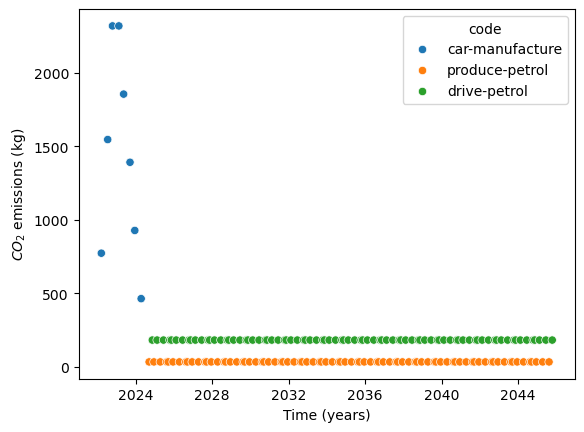

In [28]:
axes = sb.scatterplot(
    x="date", 
    y="amount",
    hue="code",
    data=df.merge(
        bd.Database('example').nodes_to_dataframe().rename(columns={'id': 'activity'}), 
        on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time (years)")

The number of points in the above graph are a function of how we chose to discretize our distribution. We could have chosen more or fewer points, though one soon reaches a point of diminishing returns when adding points, especially for flat or smooth distributions.

We can also look at cumulative emissions:

Text(0.5, 0, 'Time (years)')

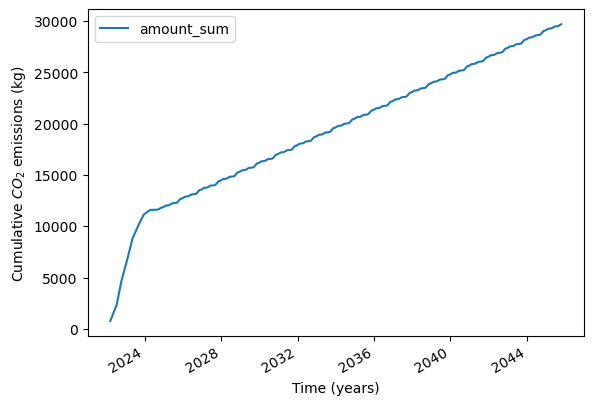

In [29]:
df["amount_sum"] = df['amount'].cumsum()
axes = df.plot(x="date", y="amount_sum")
axes.set_ylabel("Cumulative $CO_{2}$ emissions (kg)")
axes.set_xlabel("Time (years)")

We hvae so far only calcualted our *inventory* - we can also do temporally dependent impact assessment. For example, we can translate air emissions into radiative forcing. For the built-in impact assessment method, see:

* The relevant scientific publication on CRF: https://doi.org/10.5194/acp-13-2793-2013
* The relevant scientific publication on the numerical calculation of CRF: http://pubs.acs.org/doi/abs/10.1021/acs.est.5b01118

In [30]:
characterized_df = tl.characterize_dataframe(
    characterization_function=characterize_co2, 
    flow={bd.get_node(name="carbon dioxide").id},
    cumsum=True
)
characterized_df = characterized_df[characterized_df['amount'] > 0]

We can see the forcing effect of each individual emission drops off with time:

Text(0.5, 0, 'Time (years)')

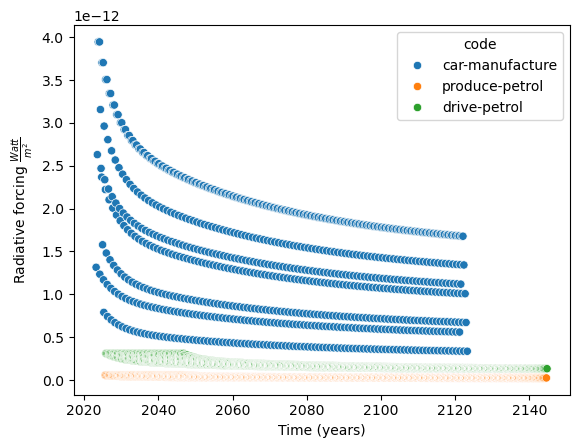

In [31]:
axes = sb.scatterplot(
    x="date", 
    y="amount",
    hue="code",
    data=characterized_df.merge(
        bd.Database('example').nodes_to_dataframe().rename(columns={'id': 'activity'}), 
        on='activity'
    )
)
axes.set_ylabel("Radiative forcing $\\frac{Watt}{m^{2}}$")
axes.set_xlabel("Time (years)")

Let's compare the three fuel options.

First, we can calculate the inventories with some helper functions:

In [32]:
def df_for_func_unit(func_unit):
    lca = bc.LCA(func_unit, ("GWP", "example"))
    lca.lci()
    lca.lcia()
    tlca = TemporalisLCA(lca)
    tl = tlca.build_timeline()
    df = tl.build_dataframe()
    df["amount_sum"] = df['amount'].cumsum()
    return df

Starting graph traversal
Calculation count: 2
Starting graph traversal
Calculation count: 3


Text(0.5, 1.0, 'Example life-cycle $CO_{2}$ emissions for a 2023 car')

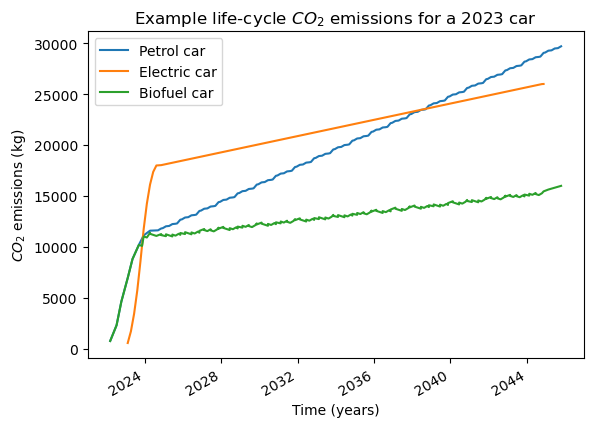

In [33]:
df['Petrol car'] = df['amount_sum']
axes = df.plot(x="date", y="Petrol car")

df2 = df_for_func_unit({('example', 'electric-car'): 1})
df2['Electric car'] = df2['amount_sum']
df2.plot(x="date", y="Electric car", ax=axes)

df3 = df_for_func_unit({('example', 'bioethanol-car'): 1})
df3['Biofuel car'] = df3['amount_sum']
df3.plot(x="date", y='Biofuel car', ax=axes)

axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time (years)")
axes.set_title("Example life-cycle $CO_{2}$ emissions for a 2023 car")

Then we can calculate the cumulative radiative forcing for all three options:

In [34]:
def characterized_df_for_func_unit(func_unit):
    lca = bc.LCA(func_unit, ("GWP", "example"))
    lca.lci()
    lca.lcia()
    tlca = TemporalisLCA(lca)
    tl = tlca.build_timeline()
    df = tl.build_dataframe()
    characterized_df = tl.characterize_dataframe(
        characterization_function=characterize_co2, 
        flow={bd.get_node(name="carbon dioxide").id},
        cumsum=False
    )
    characterized_df = characterized_df[characterized_df['amount'] > 0]
    characterized_df["amount_sum"] = characterized_df["amount"].cumsum()
    return characterized_df

Starting graph traversal
Calculation count: 2
Starting graph traversal
Calculation count: 3


Text(0.5, 0, 'Time (years)')

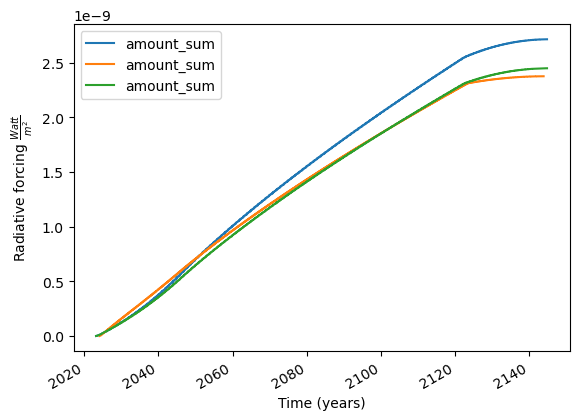

In [35]:
axes = characterized_df.plot(x="date", y="amount_sum")
characterized_df_for_func_unit({('example', 'electric-car'): 1}).plot(x="date", y="amount_sum", ax=axes)
characterized_df_for_func_unit({('example', 'bioethanol-car'): 1}).plot(x="date", y="amount_sum", ax=axes)

axes.set_ylabel("Radiative forcing $\\frac{Watt}{m^{2}}$")
axes.set_xlabel("Time (years)")